# Stable states pattern of the model

We performed the stable states analysis using the asynchronous updating methods for the model pairs to identify all possible attractors including the cyclic attractors.     
To evaluate the consistency and robustness of the merged model, the attractors patterns of both the individual models and merged models are clustered based on the hamming distance between them.


In [1]:
model1name = "Bonzanni2013"
model2name = "Krumsiek2011"

In [4]:
pip install adjustText

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import biolqm
import ginsim
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector
from rpy2.robjects.vectors import ListVector
from rpy2 import robjects
from rpy2.robjects import conversion
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
boolnet = importr("BoolNet")
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.stats import pearsonr
from adjustText import adjust_text

In [6]:
merged_and_name = "../Models/merged_and_" + model1name + "_" + model2name
merged_inhibitor_wins_name = "../Models/merged_inhibitor_wins_" + model1name + "_" + model2name
merged_or_name = "../Models/merged_or_" + model1name + "_" + model2name

# load the network
merged_and = boolnet.loadNetwork(merged_and_name + ".txt")
merged_inhibitor_wins = boolnet.loadNetwork(merged_inhibitor_wins_name + ".txt")
merged_or = boolnet.loadNetwork(merged_or_name + ".txt")

In [ ]:
# get the asynchronous attractor states
attr_and = boolnet.getAttractors(merged_and, type="asynchronous")
attr_inhibitor_wins = boolnet.getAttractors(merged_inhibitor_wins, type="asynchronous")
attr_or = boolnet.getAttractors(merged_or, type="asynchronous")

for i in range(3):
    attr = [attr_and, attr_inhibitor_wins, attr_or][i]
    df_name = ["attr_merged_and","attr_merged_inhibitor_wins","attr_merged_or"][i]
    
    # Activate the conversion context to use pandas DataFrame
    pandas2ri.activate()
    
    # Access the dataframe stored under the key '1'
    attrr = boolnet.plotAttractors(attr)
    r_df = attrr.rx2('1')
    
    # Use the local converter context to manage the conversion to a numpy array
    with localconverter(robjects.default_converter + pandas2ri.converter):
        np_array = np.array(r_df)
    
    # Extract names from the R dataframe
    row_names = list(r_df.rownames)
    column_names = list(r_df.colnames)
    
    # Save the simple attractors first
    df = pd.DataFrame(np_array, index=row_names, columns=column_names)
    df_simple = df.T
    df_simple.index = df_simple.index.str.replace('Attr', 'S')
    df_simple.to_csv('../SimulationResults/' + df_name + '_simple.csv')

    # Add the complex/loose attractors
    attrr_comp = boolnet.plotAttractors(attr ,mode = 'graph')
    for i in range(attrr.rx2('1').ncol,len(attrr_comp)):
        attr_array = attrr_comp[i][8][2][0]
        if len(attr_array[0]) == len(df):
            # Loop through each binary string in the array
            for idx, binary_str in enumerate(attr_array):
                # Convert each character in the string to an integer and add as a new column
                column_name = f'Attr{i+1}.{idx + 1}'
                df[column_name] = [int(char) for char in binary_str]
        else:
            print("The number of digits in the binary strings does not match the number of DataFrame rows.")

    df = df.T
    df.index = df.index.str.replace('Attr', 'S')
    df.to_csv('../SimulationResults/' + df_name + "_" + model1name + "_" + model2name + '.csv')

In [7]:
# Define the order of columns for better visualization
# column_order_1 = ['SMAD6','HHEX','RUNX1','CBFA2T3','ERG','GATA1','GATA2','ZFPM1', 'TAL1', 'SPI1', 'FLI1']
# column_order_2 = ['GATA1', 'GATA2', 'ZFPM1', 'TAL1', 'SPI1', 'FLI1','KLF1','CEBPA','GFI1','NAB1','EGR2','JUN','EGR1']
# column_order_merged = ['SMAD6','HHEX','RUNX1','CBFA2T3','ERG','GATA1','GATA2','ZFPM1', 'TAL1', 'SPI1', 'FLI1', 'KLF1','CEBPA','GFI1','NAB1','EGR2','JUN','EGR1']

# Model1 results
df1 = pd.read_csv("../SimulationResults/attr_" + model1name + ".csv", index_col = 0)
df1.index = df1.index.str.replace('S', 'A') #using 'A' for all stable states from the first model
# df1 = df1[column_order_1]

# Model2 results
df2 = pd.read_csv("../SimulationResults/attr_" + model2name + ".csv", index_col = 0)
df2.index = df2.index.str.replace('S', 'B') #using 'B' for all stable states from the second model
# df2 = df2[column_order_2]

# Merged results
df_and = pd.read_csv("../SimulationResults/attr_merged_and_" + model1name + "_" + model2name + '.csv', index_col = 0)
df_and.index = df_and.index.str.replace('S', 'M') #using 'M' for all stable states from the merged model
# df_and = df_and[column_order_merged]
df_and = pd.concat([df_and, df1, df2])

df_inhibitor_wins = pd.read_csv("../SimulationResults/attr_merged_inhibitor_wins_" + model1name + "_" + model2name + '.csv', index_col = 0)
df_inhibitor_wins.index = df_inhibitor_wins.index.str.replace('S', 'M')
# df_inhibitor_wins = df_inhibitor_wins[column_order_merged]
df_inhibitor_wins = pd.concat([df_inhibitor_wins, df1, df2])

df_or = pd.read_csv("../SimulationResults/attr_merged_or_" + model1name + "_" + model2name + '.csv', index_col = 0)
df_or.index = df_or.index.str.replace('S', 'M')
# df_or = df_or[column_order_merged]
df_or = pd.concat([df_or, df1, df2])

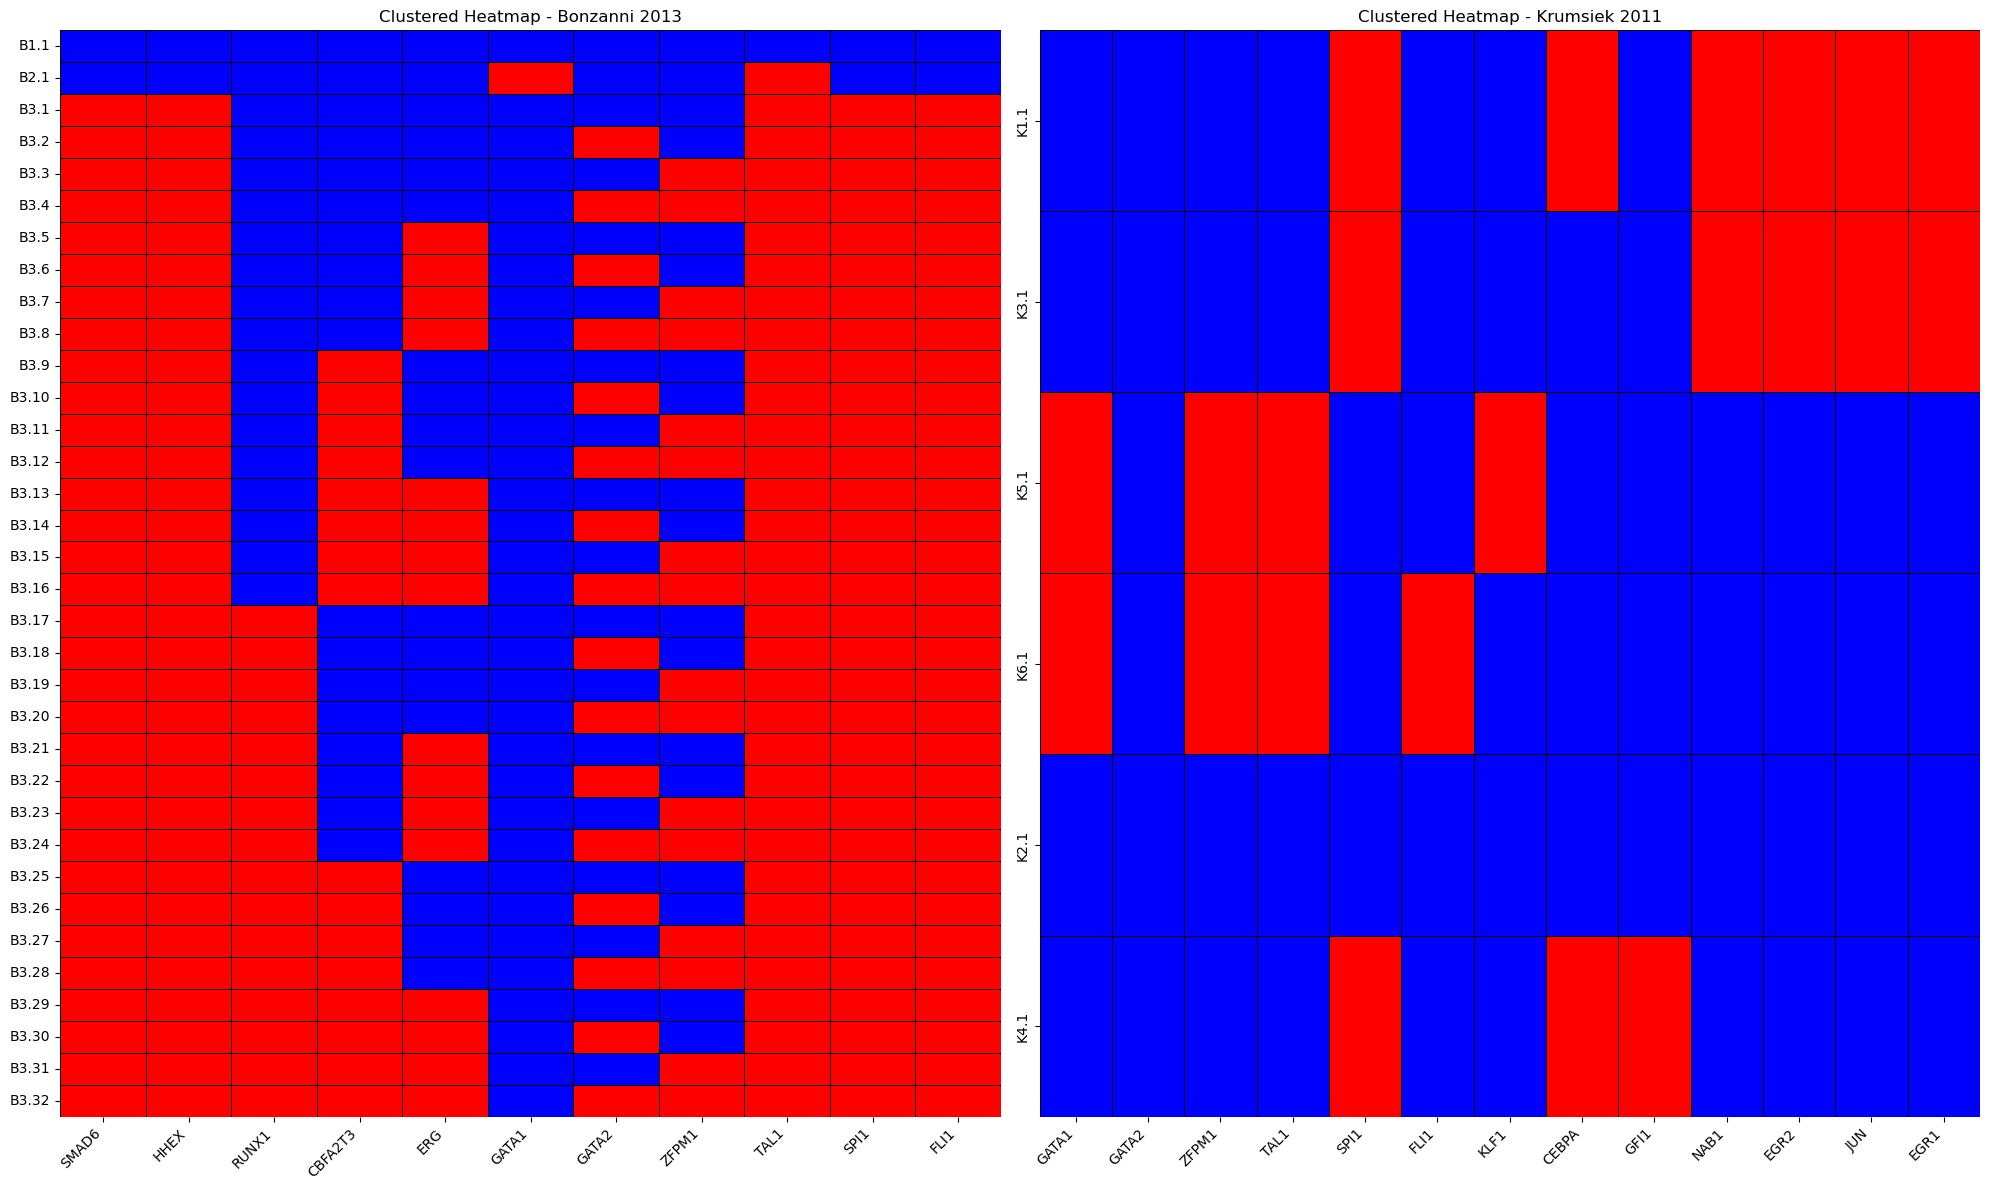

In [8]:
# Visualize
cmap = ListedColormap(['blue', 'red'])

g1 = sns.clustermap(df1, method='ward', metric='euclidean', cmap=cmap, linewidths=0.5, linecolor='black', figsize=(8, 8), cbar=False, col_cluster=False)
plt.close(g1.fig)  
g2 = sns.clustermap(df2, method='ward', metric='euclidean', cmap=cmap, linewidths=0.5, linecolor='black', figsize=(8, 8), cbar=False, col_cluster=False)
plt.close(g2.fig) 

# Create a new figure to hold both clustermaps
fig = plt.figure(figsize=(20,12))
gs = GridSpec(1, 2, figure=fig)

# Draw the first clustermap in the left subplot
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(g1.data2d, ax=ax1, cbar=False, cmap=cmap, linewidths=0.5, linecolor='black')
ax1.set_title('Clustered Heatmap - Bonzanni 2013')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')

# Draw the second clustermap in the right subplot
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(g2.data2d, ax=ax2, cbar=False, cmap=cmap, linewidths=0.5, linecolor='black')
ax2.set_title('Clustered Heatmap - Krumsiek 2011')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')

# Show the combined figure
plt.tight_layout()
plt.show()

/tmp/ipykernel_52225/1941536408.py:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((col_pos, row_pos), 1, 1, fill=True, color='lightgrey', edgecolor='black', linewidth=0.5)


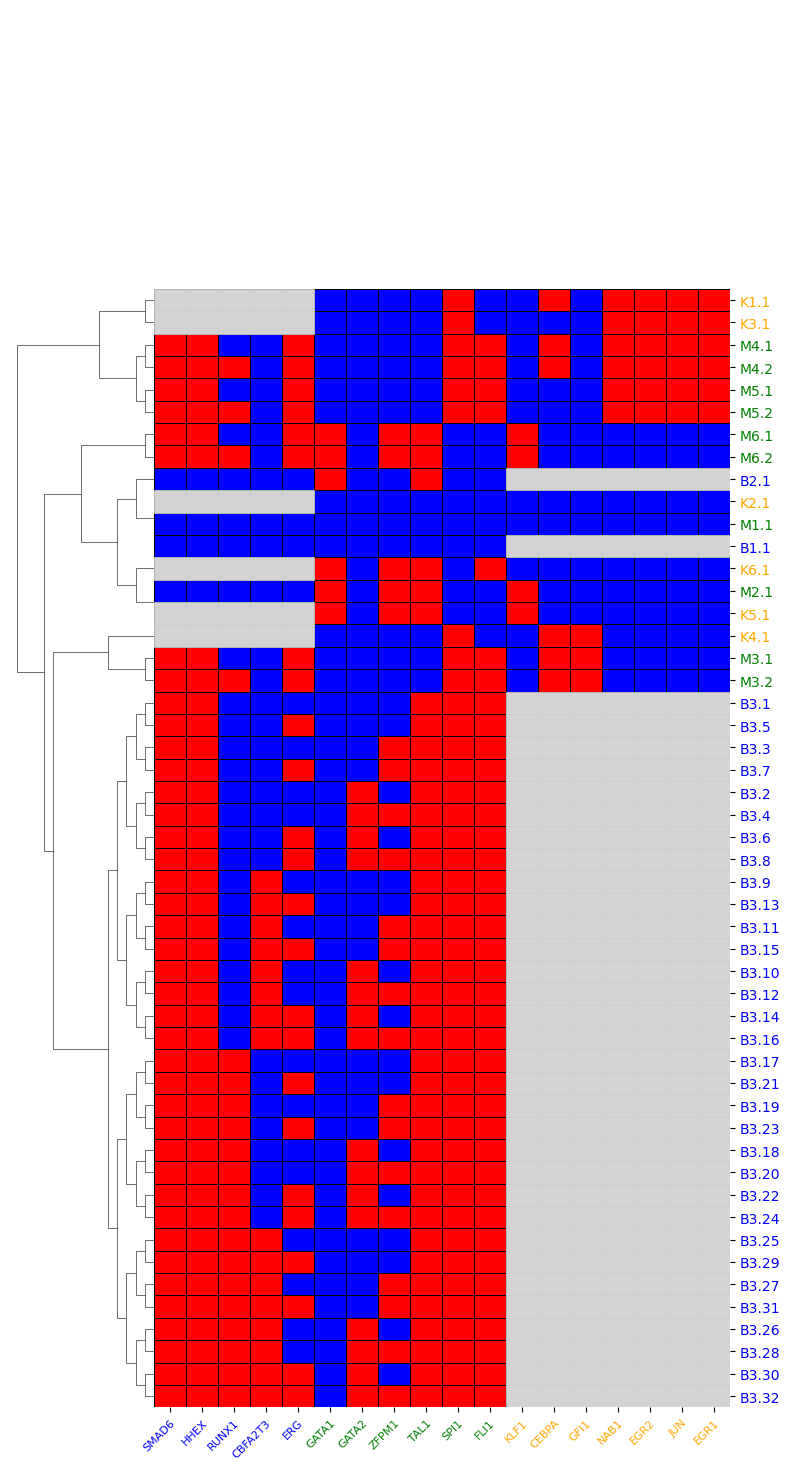

In [48]:
def heatmap(df, figsize=(8, 15)):
    # Create a custom colormap: blue for 0, red for 1
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [-0.1, 0.5, 1.1]  # Boundaries to separate colors
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # Fill NaN values with 0 for clustering
    df_filled = df.fillna(0)
    
    # Mask NaN values for clustering
    mask = df.isna()

    # Create the clustermap
    g = sns.clustermap(df_filled, method='complete', metric='hamming', cmap=cmap, norm=norm,
                       linewidths=0.5, linecolor='black', figsize=figsize, cbar=False, col_cluster=False)
    g.ax_heatmap.tick_params(axis='y', labelsize=10)
    g.ax_heatmap.tick_params(axis='x', labelsize=8)
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-tick labels
    g.cax.set_visible(False)

    # Determine the color based on the label text
    def get_ylabel_color(label):
        if label.startswith('A'):
            return 'blue'
        elif label.startswith('B'):
            return 'orange'
        elif label.startswith('M'):
            return 'green'
        else:
            return 'black'  # Default color
    
    def get_xlabel_color(label):
        if label in set(column_order_merged) - set(column_order_1):
            return 'orange'
        elif label in set(column_order_merged) - set(column_order_2):
            return 'blue'
        else:
            return 'green'
            
    # Set the color of labels based on their text
    for label in g.ax_heatmap.get_yticklabels():
        label.set_color(get_ylabel_color(label.get_text()))
    for label in g.ax_heatmap.get_xticklabels():
        label.set_color(get_xlabel_color(label.get_text()))

    # Add grey patches on NA grid cells based on clustered positions
    for (i, j), val in np.ndenumerate(df.values):
        if pd.isna(val):
            # Get the correct row and column indices in the clustered heatmap
            row_index = df.index[i]
            col_index = df.columns[j]
            # Find the positions in the clustered heatmap
            row_pos = np.where(g.data2d.index == row_index)[0][0]
            col_pos = np.where(g.data2d.columns == col_index)[0][0]
            # Create a rectangle patch with light grey fill
            rect = patches.Rectangle((col_pos, row_pos), 1, 1, fill=True, color='lightgrey', edgecolor='black', linewidth=0.5)
            g.ax_heatmap.add_patch(rect)
    
    plt.show()

heatmap(df_inhibitor_wins)

/tmp/ipykernel_52225/1941536408.py:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((col_pos, row_pos), 1, 1, fill=True, color='lightgrey', edgecolor='black', linewidth=0.5)


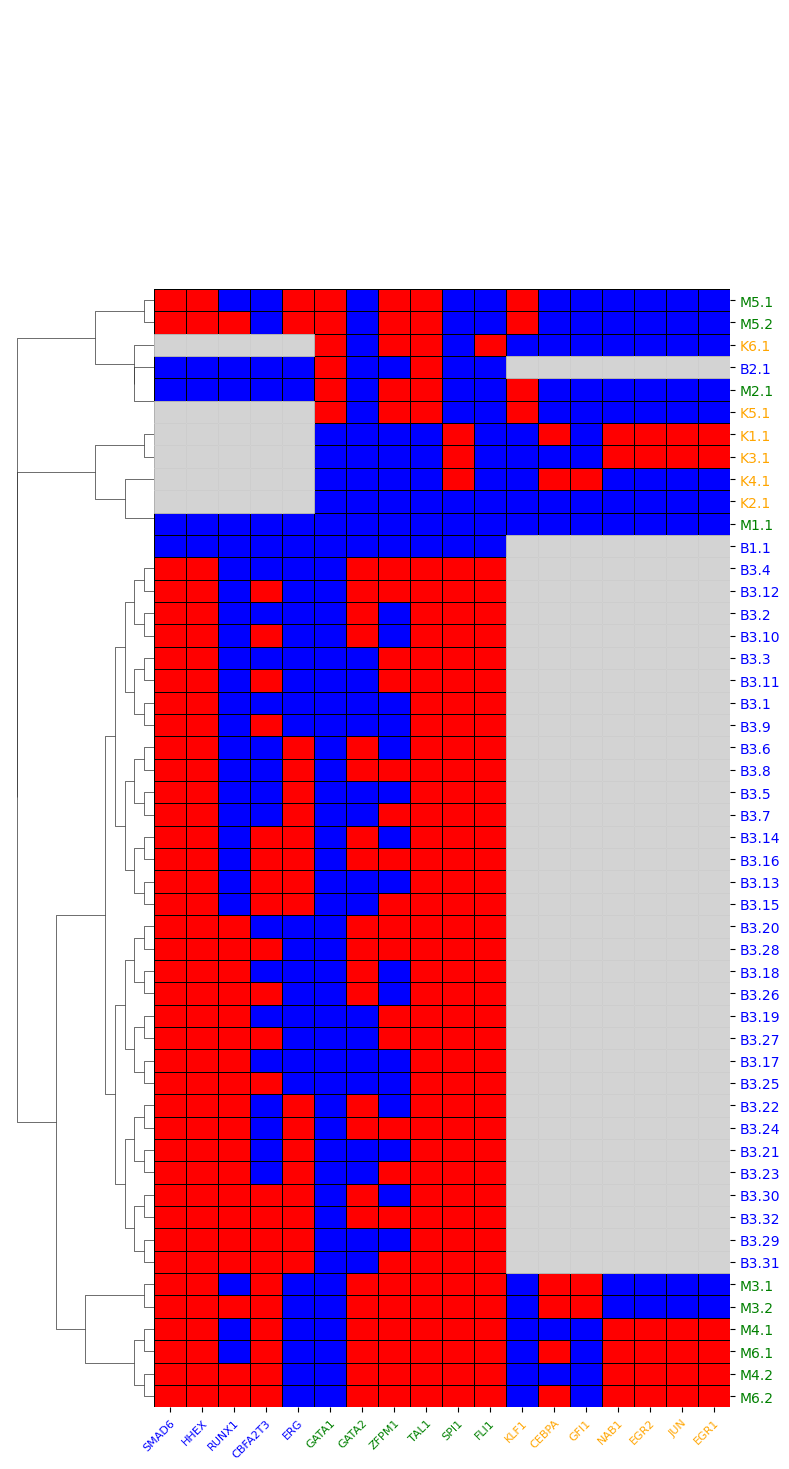

In [49]:
heatmap(df_or)

/tmp/ipykernel_52225/1941536408.py:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((col_pos, row_pos), 1, 1, fill=True, color='lightgrey', edgecolor='black', linewidth=0.5)


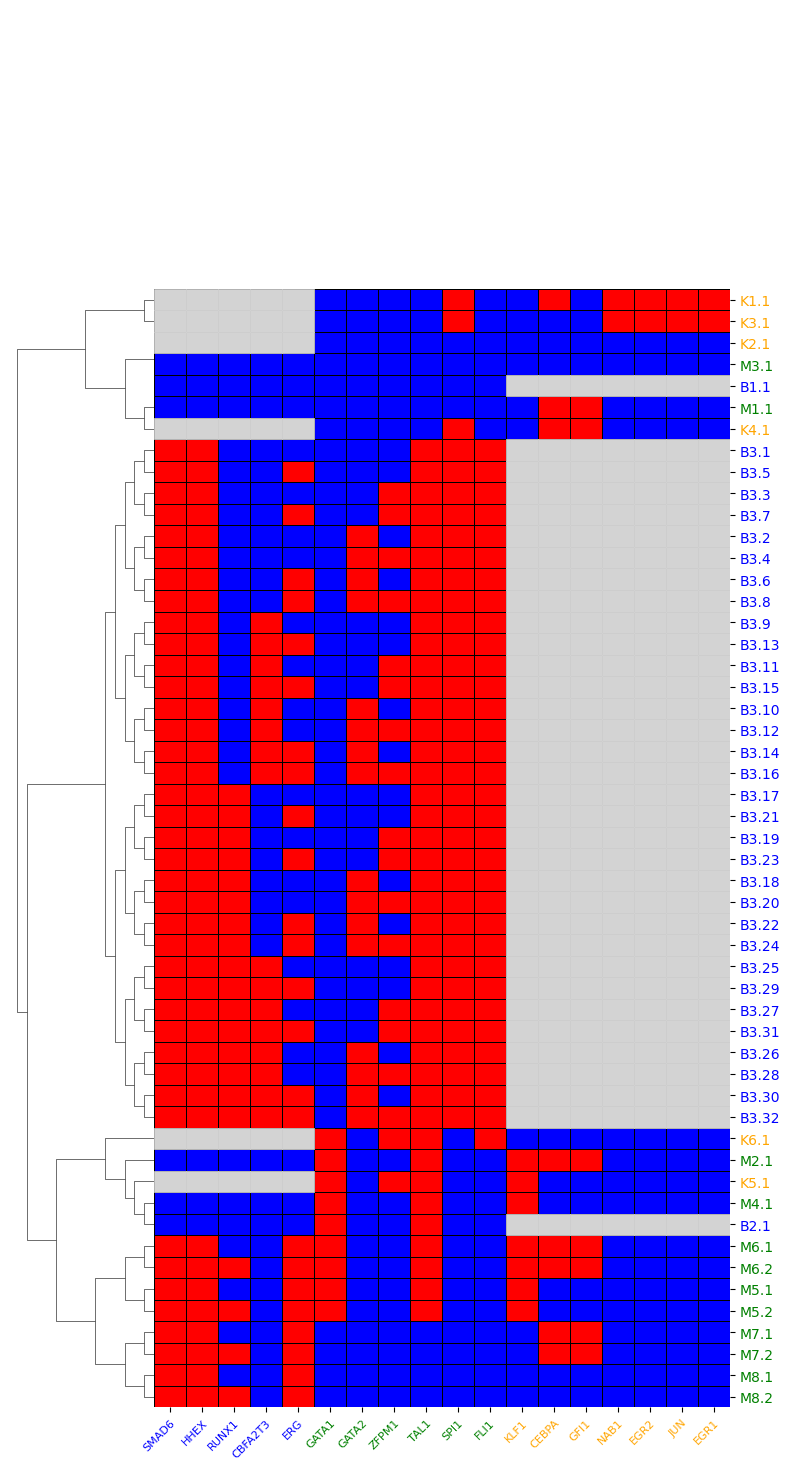

In [50]:
heatmap(df_and)

## Without the complex/loose attractors

Using synchronous updating to identify only simple attractors.

In [18]:
# Bonzanni2013 results
df1 = pd.read_csv("../SimulationResults/attr_Bonzanni2013_simple.csv", index_col = 0)
df1.index = df1.index.str.replace('S', 'B')
df1 = df1[column_order_1]

# Krumsiek2011 results
df2 = pd.read_csv("../SimulationResults/attr_Krumsiek2011.csv", index_col = 0)
df2.index = df2.index.str.replace('S', 'K')
df2 = df2[column_order_2]

# Merged results
df_and = pd.read_csv("../SimulationResults/attr_merged_and_simple.csv", index_col = 0)
df_and.index = df_and.index.str.replace('S', 'M')
df_and = df_and[column_order_merged]
df_and = pd.concat([df_and, df1, df2])

df_inhibitor_wins = pd.read_csv("../SimulationResults/attr_merged_inhibitor_wins_simple.csv", index_col = 0)
df_inhibitor_wins.index = df_inhibitor_wins.index.str.replace('S', 'M')
df_inhibitor_wins = df_inhibitor_wins[column_order_merged]
df_inhibitor_wins = pd.concat([df_inhibitor_wins, df1, df2])

df_or = pd.read_csv("../SimulationResults/attr_merged_or_simple.csv", index_col = 0)
df_or.index = df_or.index.str.replace('S', 'M')
df_or = df_or[column_order_merged]
df_or = pd.concat([df_or, df1, df2])

/tmp/ipykernel_2146/2154071251.py:48: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((j, i), 1, 1, fill=True, color='lightgrey', hatch='//', edgecolor='black', linewidth=0.5)


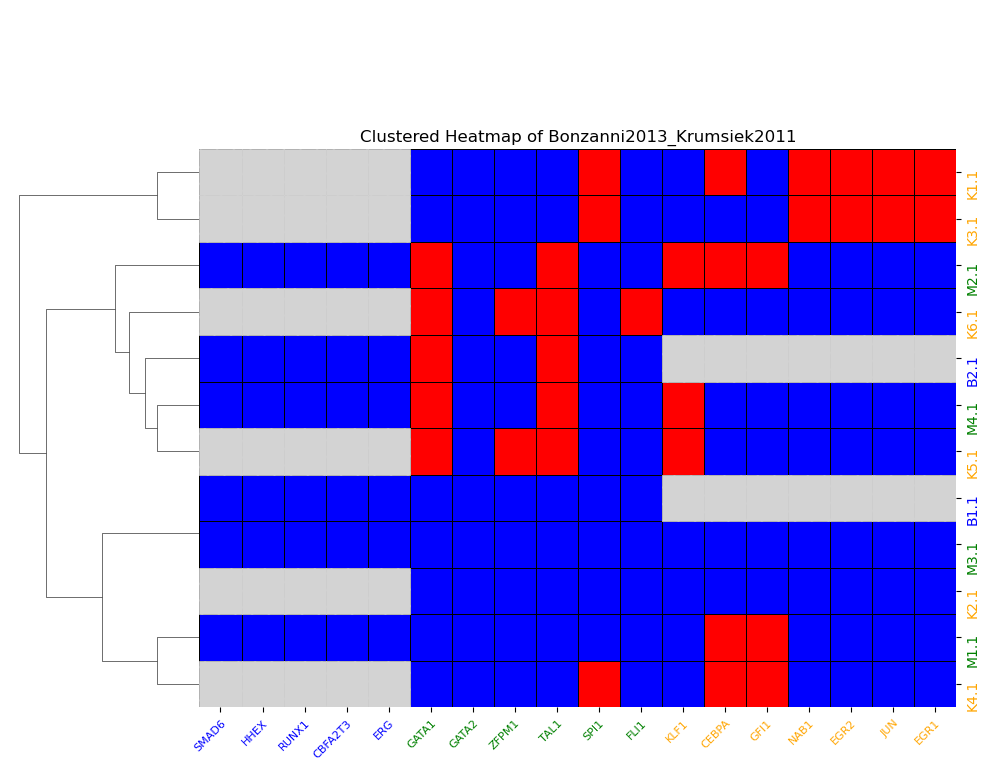

In [79]:
heatmap(df_and, figsize=(10, 8))

/tmp/ipykernel_2146/2154071251.py:48: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((j, i), 1, 1, fill=True, color='lightgrey', hatch='//', edgecolor='black', linewidth=0.5)


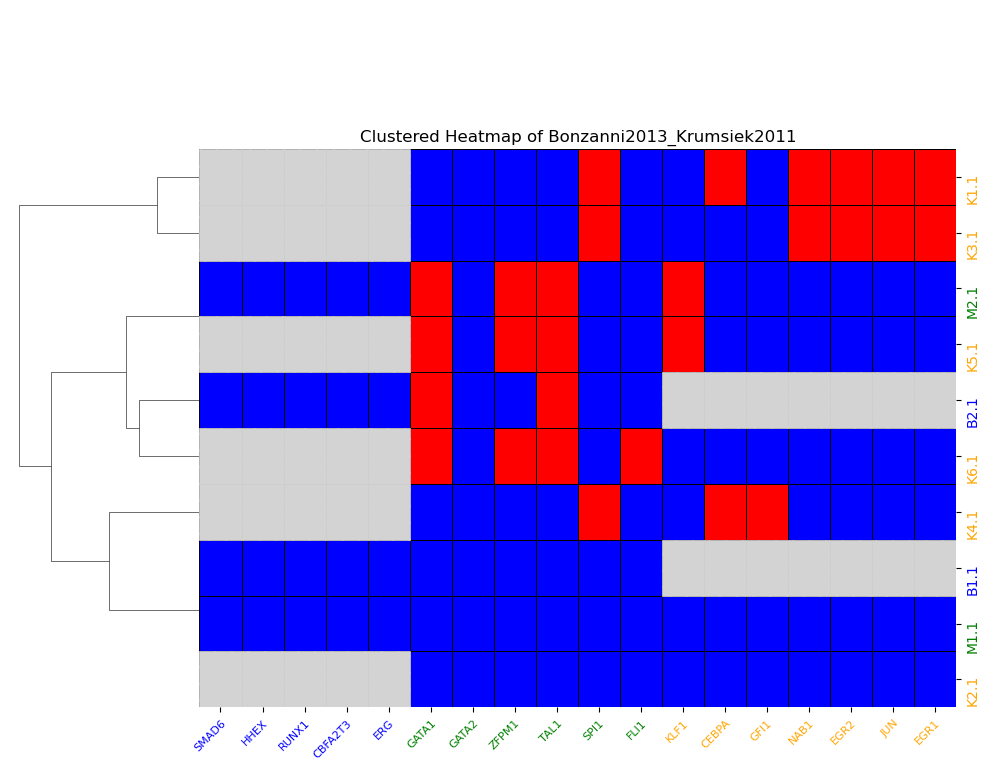

In [80]:
heatmap(df_inhibitor_wins, figsize=(10, 8))

/tmp/ipykernel_2146/2154071251.py:48: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((j, i), 1, 1, fill=True, color='lightgrey', hatch='//', edgecolor='black', linewidth=0.5)


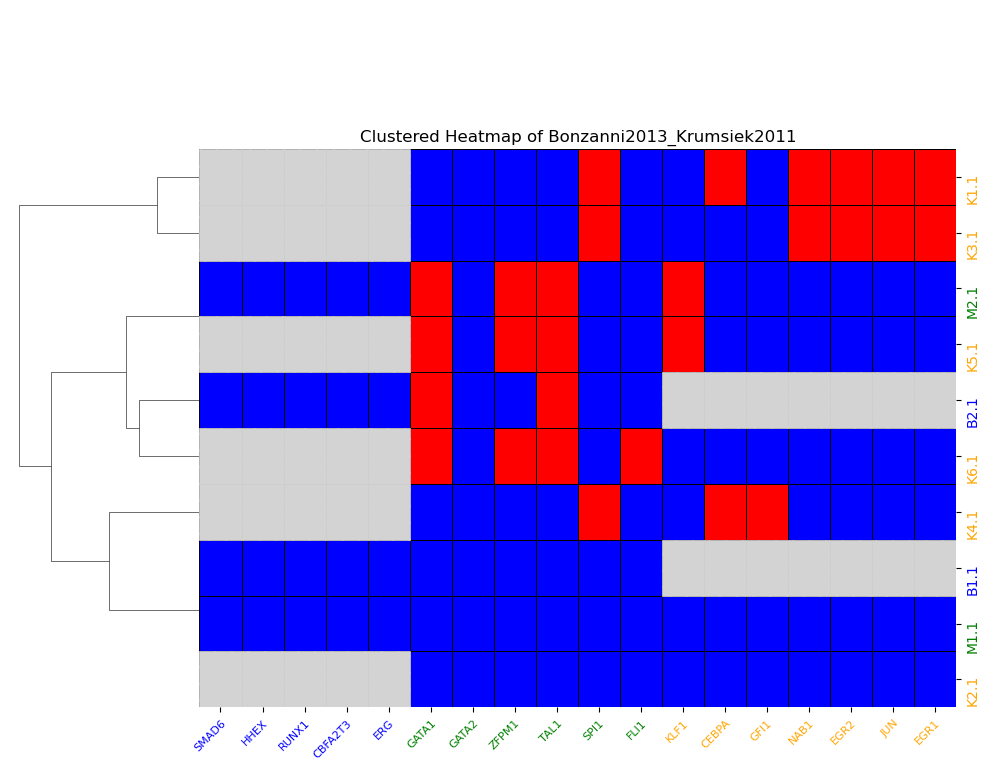

In [81]:
heatmap(df_or, figsize=(10, 8))